In [1]:
import os
import re
import pandas as pd
import numpy as np
import sys
import glob
import traceback
import datetime

sys.path.append('/lib')
sys.path.append('/data')
import lib.helper as helper

%matplotlib inline

WORKSHOP_TYPES = ["SWC", "DC", "LC", "TTT", "Circuits"]
STOPPED_WORKSHOP_TYPES = ['stalled', 'cancelled', 'unresponsive']

CURRENT_DIR = os.getcwd()
DATA_DIR = CURRENT_DIR + '/data'
RAW_DATA_DIR = DATA_DIR + '/raw'
PROCESSED_DATA_DIR = DATA_DIR + '/processed'

In [2]:
# Absolute or relative path to workshop data extracted from Carpentries Redash
workshops_file = RAW_DATA_DIR + "/redash_workshops_UK_2020_02_24.csv"

In [3]:
workshops_df = pd.read_csv(workshops_file, encoding = "utf-8")
workshops_df

,slug,venue,address,country_code,longitude,latitude,start,end,attendance,organiser,organiser_domain,organiser_country_code,tags
0,2019-10-29-cardiff,ARCHER-SSI Data Carpentry at Cardiff University,"Training Room 2, Julian Hodge Building, Colum ...",GB,-3.185430,51.491910,2019-10-29,2019-10-30,0,ARCHER,archer.ac.uk,GB,DC
1,2020-02-10-turing,"Software Carpentry Workshop, The Alan Turing I...","British Library, 96 Euston Road, London, NW1 2DB",GB,-0.127100,51.530200,2020-02-10,2020-02-11,0,Alan Turing Institute,turing.ac.uk,GB,SWC
2,2017-11-07-ukarchives,"The National Archives, Kew","J31 Park, B&Q, Motherwell Way, Aveley RM20 3EH...",GB,0.279900,51.481600,2017-11-07,2017-11-07,0,Archives and Records Association (UK & Ireland),archives.org.uk,GB,LC
3,2020-02-20-lancaster,Lancaster University,"Bowland Hall, Bailrigg, Lancaster LA1 4ZA",GB,2.789279,54.012121,2020-02-21,2020-02-22,0,CCP CoDiMa,codima.ac.uk,GB,Circuits
4,2020-xx-xx-cilip,NaN,NaN,GB,NaN,NaN,NaN,NaN,0,"CILIP, library and information association",cilip.org.uk,GB,"LC,cancelled"
5,2015-11-09-cul,NaN,NaN,GB,-0.101594,51.528039,2015-11-09,2015-11-30,59,"City, University of London",city.ac.uk,GB,LC
6,2014-07-21-cranfield,Cranfield University,"Computer Teaching Suite (room 252), Whittle Bu...",GB,-0.629225,52.074389,2014-07-21,2014-07-23,28,Cranfield University,cranfield.ac.uk,GB,SWC
7,2015-11-09-culham,Culham Centre for Fusion Energy,"Abingdon, Oxfordshire, OX14 3DB, UK",GB,-1.228790,51.657608,2015-11-09,2015-11-10,43,Culham Centre for Fusion Energy,ccfe.ac.uk,GB,SWC
8,2020-02-25-KRAKOW-TEST,Manchester University,NaN,GB,NaN,NaN,2020-02-25,2020-02-26,0,Cyfronet,cyfronet.pl,PL,"LC,automated-email"
9,2018-06-12-bru-datacarpentry-inbo-elixir,U-residence,"Generaal Jacqueslaan 271, 1050 Brussels",BE,4.394176,50.824343,2018-06-12,2018-06-13,17,ELIXIR-UK,elixir-uk.org,GB,DC


In [4]:
# Convert column "tags" from a string to a list of strings
idx = workshops_df.columns.get_loc("tags")
workshops_df.insert(loc=idx, column='tags_list', value=workshops_df["tags"])
workshops_df["tags_list"] = workshops_df["tags"].str.split(',')

In [5]:
# Check we indeed have created a list of tags
workshops_df.tags_list[4]

['LC', 'cancelled']

In [6]:
# Extract workshop type ('SWC', 'DC', 'LC', 'Circuits', 'TTT') and status ('cancelled', 'unresponsive', 'stalled', "Pilot") 
# and add as a new column
idx = workshops_df.columns.get_loc("tags_list")
workshops_df.insert(loc=idx, column='workshop_type',
                            value=workshops_df["tags_list"])
workshops_df["workshop_type"] = workshops_df["tags_list"].map(helper.extract_workshop_type, na_action="ignore")
workshops_df

,slug,venue,address,country_code,longitude,latitude,start,end,attendance,organiser,organiser_domain,organiser_country_code,workshop_type,tags_list,tags
0,2019-10-29-cardiff,ARCHER-SSI Data Carpentry at Cardiff University,"Training Room 2, Julian Hodge Building, Colum ...",GB,-3.185430,51.491910,2019-10-29,2019-10-30,0,ARCHER,archer.ac.uk,GB,DC,[DC],DC
1,2020-02-10-turing,"Software Carpentry Workshop, The Alan Turing I...","British Library, 96 Euston Road, London, NW1 2DB",GB,-0.127100,51.530200,2020-02-10,2020-02-11,0,Alan Turing Institute,turing.ac.uk,GB,SWC,[SWC],SWC
2,2017-11-07-ukarchives,"The National Archives, Kew","J31 Park, B&Q, Motherwell Way, Aveley RM20 3EH...",GB,0.279900,51.481600,2017-11-07,2017-11-07,0,Archives and Records Association (UK & Ireland),archives.org.uk,GB,LC,[LC],LC
3,2020-02-20-lancaster,Lancaster University,"Bowland Hall, Bailrigg, Lancaster LA1 4ZA",GB,2.789279,54.012121,2020-02-21,2020-02-22,0,CCP CoDiMa,codima.ac.uk,GB,Circuits,[Circuits],Circuits
4,2020-xx-xx-cilip,NaN,NaN,GB,NaN,NaN,NaN,NaN,0,"CILIP, library and information association",cilip.org.uk,GB,LC,"[LC, cancelled]","LC,cancelled"
5,2015-11-09-cul,NaN,NaN,GB,-0.101594,51.528039,2015-11-09,2015-11-30,59,"City, University of London",city.ac.uk,GB,LC,[LC],LC
6,2014-07-21-cranfield,Cranfield University,"Computer Teaching Suite (room 252), Whittle Bu...",GB,-0.629225,52.074389,2014-07-21,2014-07-23,28,Cranfield University,cranfield.ac.uk,GB,SWC,[SWC],SWC
7,2015-11-09-culham,Culham Centre for Fusion Energy,"Abingdon, Oxfordshire, OX14 3DB, UK",GB,-1.228790,51.657608,2015-11-09,2015-11-10,43,Culham Centre for Fusion Energy,ccfe.ac.uk,GB,SWC,[SWC],SWC
8,2020-02-25-KRAKOW-TEST,Manchester University,NaN,GB,NaN,NaN,2020-02-25,2020-02-26,0,Cyfronet,cyfronet.pl,PL,LC,"[LC, automated-email]","LC,automated-email"
9,2018-06-12-bru-datacarpentry-inbo-elixir,U-residence,"Generaal Jacqueslaan 271, 1050 Brussels",BE,4.394176,50.824343,2018-06-12,2018-06-13,17,ELIXIR-UK,elixir-uk.org,GB,DC,[DC],DC


In [7]:
# How many workshops that do not have a workshop type?
print(workshops_df[workshops_df['workshop_type']==""][["slug", "tags_list"]])
print(workshops_df[workshops_df['workshop_type']==""]['workshop_type'].count())

                       slug        tags_list
37            2018-10-02-DC      [cancelled]
87   2016-04-26-london-nrgi        [stalled]
98        2017-02-13-oxford      [cancelled]
136       2017-04-27-london      [cancelled]
162         2018-01-xx-bath        [stalled]
175  2018-09-xx-bradford-dc      [cancelled]
196       2018-09-05-dundee      [cancelled]
248        2016-09-14-leeds      [cancelled]
267     2017-01-xx-bradford        [stalled]
301       2016-11-14-oxford        [stalled]
306       2018-10-17-oxford      [cancelled]
308       2019-03-19-oxford      [cancelled]
343      2018-06-xx-glasgow   [unresponsive]
345       2017-07-12-sussex  [WiSE, stalled]
14


In [8]:
# Extract 'stopped' workshop status, normally ('cancelled', 'unresponsive', 'stalled'), and separate from the workshop's type
idx = workshops_df.columns.get_loc("tags_list")
workshops_df.insert(loc=idx, column='workshop_status',
                            value=workshops_df["tags_list"])
workshops_df["workshop_status"] = workshops_df["tags_list"].map(helper.extract_workshop_status, na_action="ignore")

In [9]:
# How many workshops that do not have a status?
print(workshops_df[workshops_df['workshop_status']==""][["slug", "workshop_type", "tags"]])
print(workshops_df[workshops_df['workshop_status']==""]['workshop_status'].count())

print("Total workshops: " + str(len(workshops_df.index)))

                                         slug workshop_type  \
0                          2019-10-29-cardiff            DC   
1                           2020-02-10-turing           SWC   
2                       2017-11-07-ukarchives            LC   
3                        2020-02-20-lancaster      Circuits   
5                              2015-11-09-cul            LC   
6                        2014-07-21-cranfield           SWC   
7                           2015-11-09-culham           SWC   
8                      2020-02-25-KRAKOW-TEST            LC   
9    2018-06-12-bru-datacarpentry-inbo-elixir            DC   
10                           2018-03-28-paris           SWC   
13                 2018-12-01-elixir-debrecen           SWC   
14                           2018-10-24-ugent           SWC   
15            2019-04-01-ELIXIR-NORWAY_BERGEN           SWC   
16                          2019-02-11-Naples           SWC   
18                   2019-02-14-elixir-milano          

In [10]:
# How many "stopped" workshops are there?
workshops_df[(workshops_df['workshop_status'].isin(STOPPED_WORKSHOP_TYPES))]['workshop_status'].value_counts()

stalled         13
cancelled       13
unresponsive     5
Name: workshop_status, dtype: int64

In [11]:
# How many "Circuits" workshops are there?
workshops_df[workshops_df['workshop_type'] == 'Circuits']

,slug,venue,address,country_code,longitude,latitude,start,end,attendance,organiser,organiser_domain,organiser_country_code,workshop_type,workshop_status,tags_list,tags
3,2020-02-20-lancaster,Lancaster University,"Bowland Hall, Bailrigg, Lancaster LA1 4ZA",GB,2.789279,54.012121,2020-02-21,2020-02-22,0,CCP CoDiMa,codima.ac.uk,GB,Circuits,,[Circuits],Circuits
86,2019-11-15-edinburgh-library-carpentry,University of Edinburgh,"Digital Scholarship Centre, Floor 6, Universit...",GB,-3.188267,55.953251,2019-11-15,2020-05-01,0,National Library of Scotland,nls.uk,GB,Circuits,,[Circuits],Circuits
159,2019-11-19-aberystwyth,Aberystwyth University,"Old College, King Street",GB,-4.088170,52.414590,2019-11-19,2019-11-20,0,University of Aberystwyth,aber.ac.uk,GB,Circuits,,[Circuits],Circuits
160,2019-11-06-aberystwyth,Aberystwyth University,G24 Cledwyn Building,GB,-4.067130,52.417040,2019-11-06,2019-11-13,0,University of Aberystwyth,aber.ac.uk,GB,Circuits,,[Circuits],Circuits
226,2019-10-07-unixshell,"Medical Education Centre, Computing Lab","MEC, The Anne. Ferguson Building. WGH",GB,-3.234058,55.962345,2019-10-07,2019-10-07,0,University of Edinburgh,ed.ac.uk,GB,Circuits,,[Circuits],Circuits
286,2019-12-11-durham,Library Carpentry NE England at Durham University,"Bill Bryson Library, Stockton Road, Durham, Du...",GB,-1.573079,54.768265,2019-12-11,2019-12-11,0,University of Manchester,manchester.ac.uk,GB,Circuits,,[Circuits],Circuits
331,2019-11-19-southampton-swc,Astronomy & Astrophysics,"Seminar Room, Building 46",GB,-1.395950,50.934630,2019-11-19,2019-11-19,0,University of Southampton,southampton.ac.uk,GB,Circuits,,[Circuits],Circuits


In [12]:
# Insert countries where workshops were held based on country_code
idx = workshops_df.columns.get_loc("country_code")
workshops_df.insert(loc=idx + 1, column='country',
                            value=workshops_df["country_code"])
# workshops_df["country"] = workshops_df["country_code"].map(helper.get_country, na_action="ignore")
# workshops_df

countries = pd.read_csv("lib/country_codes.csv", encoding = "utf-8", keep_default_na = False) # keep_default_na prevents Namibia "NA" being read as NaN!
countries_mapping = dict(countries[['country_code', 'country_name']].values)
print(countries_mapping)
workshops_df['country'] = workshops_df['country_code'].map(countries_mapping, na_action="ignore")
workshops_df.head

{'AF': 'Afghanistan', 'AX': 'Ã…land Islands', 'AL': 'Albania', 'DZ': 'Algeria', 'AS': 'American Samoa', 'AD': 'Andorra', 'AO': 'Angola', 'AI': 'Anguilla', 'AQ': 'Antarctica', 'AG': 'Antigua and Barbuda', 'AR': 'Argentina', 'AM': 'Armenia', 'AW': 'Aruba', 'AU': 'Australia', 'AT': 'Austria', 'AZ': 'Azerbaijan', 'BS': 'Bahamas', 'BH': 'Bahrain', 'BD': 'Bangladesh', 'BB': 'Barbados', 'BY': 'Belarus', 'BE': 'Belgium', 'BZ': 'Belize', 'BJ': 'Benin', 'BM': 'Bermuda', 'BT': 'Bhutan', 'BO': 'Bolivia, Plurinational State of', 'BQ': 'Bonaire, Sint Eustatius and Saba', 'BA': 'Bosnia and Herzegovina', 'BW': 'Botswana', 'BV': 'Bouvet Island', 'BR': 'Brazil', 'IO': 'British Indian Ocean Territory', 'BN': 'Brunei Darussalam', 'BG': 'Bulgaria', 'BF': 'Burkina Faso', 'BI': 'Burundi', 'KH': 'Cambodia', 'CM': 'Cameroon', 'CA': 'Canada', 'CV': 'Cape Verde', 'KY': 'Cayman Islands', 'CF': 'Central African Republic', 'TD': 'Chad', 'CL': 'Chile', 'CN': 'China', 'CX': 'Christmas Island', 'CC': 'Cocos (Keeling) 

<bound method NDFrame.head of                                          slug  \
0                          2019-10-29-cardiff   
1                           2020-02-10-turing   
2                       2017-11-07-ukarchives   
3                        2020-02-20-lancaster   
4                            2020-xx-xx-cilip   
5                              2015-11-09-cul   
6                        2014-07-21-cranfield   
7                           2015-11-09-culham   
8                      2020-02-25-KRAKOW-TEST   
9    2018-06-12-bru-datacarpentry-inbo-elixir   
10                           2018-03-28-paris   
11                  2018-10-13-Hungary-elixir   
12               2019-02-14-elixir-luxembourg   
13                 2018-12-01-elixir-debrecen   
14                           2018-10-24-ugent   
15            2019-04-01-ELIXIR-NORWAY_BERGEN   
16                          2019-02-11-Naples   
17                      2018-10-15-elixir-igc   
18                   2019-02-14-elixir-

In [13]:
# How many workshops are not from the UK?
print(workshops_df[workshops_df['country_code'] != "GB"])
# How many workshops are missing country information?
workshops_df[workshops_df['country_code'].isnull()]

                                         slug  \
9    2018-06-12-bru-datacarpentry-inbo-elixir   
10                           2018-03-28-paris   
11                  2018-10-13-Hungary-elixir   
12               2019-02-14-elixir-luxembourg   
13                 2018-12-01-elixir-debrecen   
14                           2018-10-24-ugent   
15            2019-04-01-ELIXIR-NORWAY_BERGEN   
16                          2019-02-11-Naples   
17                      2018-10-15-elixir-igc   
18                   2019-02-14-elixir-milano   
19                   2018-02-14-elixir-prague   
20              2018-12-03-elixir-netherlands   
21                   2019-01-10-elixir-athens   
22                2019-01-29-elixir-Ljubljana   
23                   2019-07-01-elixir-sib-dc   
25                           2019-05-13-Ghent   
26                             2019-04-16-BRU   
27                       2019-04-01-elxir-csc   
28                 2018-05-16-elixir-slovenia   
29                  

,slug,venue,address,country_code,country,longitude,latitude,start,end,attendance,organiser,organiser_domain,organiser_country_code,workshop_type,workshop_status,tags_list,tags
12,2019-02-14-elixir-luxembourg,NaN,NaN,NaN,NaN,NaN,NaN,2019-02-11,2019-02-15,0,ELIXIR-UK,elixir-uk.org,GB,SWC,cancelled,"[SWC, cancelled]","SWC,cancelled"
20,2018-12-03-elixir-netherlands,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-03,2018-12-07,0,ELIXIR-UK,elixir-uk.org,GB,DC,cancelled,"[DC, cancelled]","DC,cancelled"
47,2017-01-xx-oxford,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,First Light Fusion,firstlightfusion.com,GB,SWC,stalled,"[SWC, stalled]","SWC,stalled"
229,2020-02-12-edinburgh,"Room 4.2, Lister Building","5 Roxburgh Pl, Edinburgh EH8 9SU",NaN,NaN,-3.184209,55.947159,2020-02-12,2020-03-04,0,University of Edinburgh,ed.ac.uk,GB,DC,,[DC],DC
306,2018-10-17-oxford,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-17,2018-10-18,0,University of Oxford,ox.ac.uk,GB,,cancelled,[cancelled],cancelled
344,2018-12-xx-sussex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,University of Sussex,sussex.ac.uk,GB,SWC,stalled,"[SWC, stalled]","SWC,stalled"
345,2017-07-12-sussex,NaN,NaN,NaN,NaN,NaN,NaN,2017-07-12,2017-07-12,0,University of Sussex,sussex.ac.uk,GB,,stalled,"[WiSE, stalled]","WiSE,stalled"


Total workshops organised by the UK in other countries: 26
                                         slug         country
9    2018-06-12-bru-datacarpentry-inbo-elixir         Belgium
10                           2018-03-28-paris          France
11                  2018-10-13-Hungary-elixir         Hungary
12               2019-02-14-elixir-luxembourg             NaN
13                 2018-12-01-elixir-debrecen         Hungary
14                           2018-10-24-ugent         Belgium
15            2019-04-01-ELIXIR-NORWAY_BERGEN          Norway
16                          2019-02-11-Naples           Italy
17                      2018-10-15-elixir-igc        Portugal
18                   2019-02-14-elixir-milano           Italy
19                   2018-02-14-elixir-prague  Czech Republic
20              2018-12-03-elixir-netherlands             NaN
21                   2019-01-10-elixir-athens          Greece
22                2019-01-29-elixir-Ljubljana        Slovenia
23         

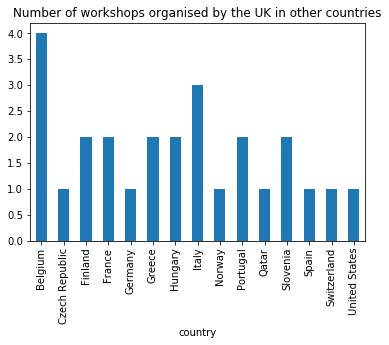

In [14]:
# How many workshops organised by UK institutions but outside of UK?
print("Total workshops organised by the UK in other countries: " + 
      str(workshops_df[workshops_df['country_code'] != "GB"]['country_code'].count()))
workshops_outside_UK = workshops_df[workshops_df['country_code'] != "GB"]
print(workshops_outside_UK[['slug', 'country']])

workshops_outside_UK_per_country = workshops_outside_UK.groupby(['country'])['country'].count()
workshops_outside_UK_per_country.plot(kind='bar', stacked=True, title="Number of workshops organised by the UK in other countries")
print(workshops_outside_UK_per_country)

In [15]:
# Add UK region for a workshop based on its geocoordinates as a new column
idx = workshops_df.columns.get_loc("country")
workshops_df.insert(loc=idx + 1, column='region',
                            value=workshops_df["country_code"])
workshops_df['region'] = workshops_df.apply(lambda x: helper.get_uk_region(latitude=x['latitude'],
                                    longitude=x['longitude']), axis=1)
print("\n################################\nThis took a while but it has finished now")

Looking up region for geocoordinates: (51.49191, -3.1854299999999998)
Looking up region for geocoordinates: (51.5302, -0.1271)
Looking up region for geocoordinates: (51.4816, 0.2799)
Looking up region for geocoordinates: (54.01212099999999, 2.789279)
Could no find UK region for location (54.01212099999999, 2.789279)
Looking up region for geocoordinates: (nan, nan)
Could no find UK region for location (nan, nan)
Looking up region for geocoordinates: (51.5280395, -0.1015937)
Looking up region for geocoordinates: (52.074389000000004, -0.629225)
Looking up region for geocoordinates: (51.6576076, -1.2287899)
Looking up region for geocoordinates: (nan, nan)
Could no find UK region for location (nan, nan)
Looking up region for geocoordinates: (50.824343, 4.394176)
Could no find UK region for location (50.824343, 4.394176)
Looking up region for geocoordinates: (48.840447, 2.310683)
Could no find UK region for location (48.840447, 2.310683)
Looking up region for geocoordinates: (nan, nan)
Could

In [16]:
# Add UK region for a workshop based on its organiser (lookup UK academic institutitons and HESA data) as a new column
uk_academic_institutions = pd.read_csv("lib/UK-academic-institutions.csv", encoding = "utf-8")
hesa_UK_higher_education_providers = pd.read_csv("lib/HESA_UK_higher_education_providers.csv", encoding = "utf-8")
hesa_UK_higher_education_providers_region_mapping = dict(hesa_UK_higher_education_providers[['UKPRN', 'Region']].values) # create a dict for lookup

uk_academic_institutions['domain'] = uk_academic_institutions['WEBSITE_URL'].apply(lambda x: x.strip("http://www.").strip("/")) # strip 'http://www' from domain
uk_academic_institutions['region'] = uk_academic_institutions['UKPRN'].map(hesa_UK_higher_education_providers_region_mapping, na_action="ignore")
print(uk_academic_institutions)

uk_academic_institutions_region_mapping = dict(uk_academic_institutions[['domain', 'region']].values) # create a dict for lookup

idx = workshops_df.columns.get_loc("organiser_country_code")
workshops_df.insert(loc=idx + 1, column='organiser_region', value=workshops_df["organiser_domain"])
workshops_df['organiser_region'] = workshops_df['organiser_region'].map(uk_academic_institutions_region_mapping,na_action="ignore")
workshops_df.head(5)

        UKPRN                                      PROVIDER_NAME  \
0    10008640                                FALMOUTH UNIVERSITY   
1    10007774                               UNIVERSITY OF OXFORD   
2    10007768                            UNIVERSITY OF LANCASTER   
3    10000571                                BATH SPA UNIVERSITY   
4    10007814                                 CARDIFF UNIVERSITY   
5    10007158                          UNIVERSITY OF SOUTHAMPTON   
6    10007779                       THE ROYAL VETERINARY COLLEGE   
7    10007851                                UNIVERSITY OF DERBY   
8    10000824                             BOURNEMOUTH UNIVERSITY   
9    10007162                     UNIVERSITY OF THE ARTS, LONDON   
10   10007804                             UNIVERSITY OF STIRLING   
11   10007823                               EDGE HILL UNIVERSITY   
12   10007160                               UNIVERSITY OF SURREY   
13   10007791                                UNI

,slug,venue,address,country_code,country,region,longitude,latitude,start,end,attendance,organiser,organiser_domain,organiser_country_code,organiser_region,workshop_type,workshop_status,tags_list,tags
0,2019-10-29-cardiff,ARCHER-SSI Data Carpentry at Cardiff University,"Training Room 2, Julian Hodge Building, Colum ...",GB,United Kingdom,Wales,-3.185430,51.491910,2019-10-29,2019-10-30,0,ARCHER,archer.ac.uk,GB,NaN,DC,,[DC],DC
1,2020-02-10-turing,"Software Carpentry Workshop, The Alan Turing I...","British Library, 96 Euston Road, London, NW1 2DB",GB,United Kingdom,London,-0.127100,51.530200,2020-02-10,2020-02-11,0,Alan Turing Institute,turing.ac.uk,GB,NaN,SWC,,[SWC],SWC
2,2017-11-07-ukarchives,"The National Archives, Kew","J31 Park, B&Q, Motherwell Way, Aveley RM20 3EH...",GB,United Kingdom,Eastern,0.279900,51.481600,2017-11-07,2017-11-07,0,Archives and Records Association (UK & Ireland),archives.org.uk,GB,NaN,LC,,[LC],LC
3,2020-02-20-lancaster,Lancaster University,"Bowland Hall, Bailrigg, Lancaster LA1 4ZA",GB,United Kingdom,None,2.789279,54.012121,2020-02-21,2020-02-22,0,CCP CoDiMa,codima.ac.uk,GB,NaN,Circuits,,[Circuits],Circuits
4,2020-xx-xx-cilip,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,0,"CILIP, library and information association",cilip.org.uk,GB,NaN,LC,cancelled,"[LC, cancelled]","LC,cancelled"


In [17]:
print(workshops_df.columns)
workshops_df[workshops_df['region'].isnull()]

Index(['slug', 'venue', 'address', 'country_code', 'country', 'region',
       'longitude', 'latitude', 'start', 'end', 'attendance', 'organiser',
       'organiser_domain', 'organiser_country_code', 'organiser_region',
       'workshop_type', 'workshop_status', 'tags_list', 'tags'],
      dtype='object')


,slug,venue,address,country_code,country,region,longitude,latitude,start,end,attendance,organiser,organiser_domain,organiser_country_code,organiser_region,workshop_type,workshop_status,tags_list,tags
3,2020-02-20-lancaster,Lancaster University,"Bowland Hall, Bailrigg, Lancaster LA1 4ZA",GB,United Kingdom,None,2.789279,54.012121,2020-02-21,2020-02-22,0,CCP CoDiMa,codima.ac.uk,GB,NaN,Circuits,,[Circuits],Circuits
4,2020-xx-xx-cilip,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,0,"CILIP, library and information association",cilip.org.uk,GB,NaN,LC,cancelled,"[LC, cancelled]","LC,cancelled"
8,2020-02-25-KRAKOW-TEST,Manchester University,NaN,GB,United Kingdom,None,NaN,NaN,2020-02-25,2020-02-26,0,Cyfronet,cyfronet.pl,PL,NaN,LC,,"[LC, automated-email]","LC,automated-email"
9,2018-06-12-bru-datacarpentry-inbo-elixir,U-residence,"Generaal Jacqueslaan 271, 1050 Brussels",BE,Belgium,None,4.394176,50.824343,2018-06-12,2018-06-13,17,ELIXIR-UK,elixir-uk.org,GB,NaN,DC,,[DC],DC
10,2018-03-28-paris,Institut Pasteur Paris,"25-28 Rue du Dr Roux, 75015 Paris",FR,France,None,2.310683,48.840447,2018-03-28,2018-03-29,12,ELIXIR-UK,elixir-uk.org,GB,NaN,SWC,,[SWC],SWC
11,2018-10-13-Hungary-elixir,NaN,NaN,HU,Hungary,None,NaN,NaN,NaN,NaN,0,ELIXIR-UK,elixir-uk.org,GB,NaN,DC,stalled,"[DC, stalled]","DC,stalled"
12,2019-02-14-elixir-luxembourg,NaN,NaN,NaN,NaN,None,NaN,NaN,2019-02-11,2019-02-15,0,ELIXIR-UK,elixir-uk.org,GB,NaN,SWC,cancelled,"[SWC, cancelled]","SWC,cancelled"
13,2018-12-01-elixir-debrecen,"University of Debrecen, Medical Faculty","Dean's Office, International Training Coordina...",HU,Hungary,None,21.635170,47.539860,2018-12-01,2018-12-02,31,ELIXIR-UK,elixir-uk.org,GB,NaN,SWC,,[SWC],SWC
14,2018-10-24-ugent,University of Ghent,"Room: Vergaderzaal B0.1, Campus Coupure, Coupu...",BE,Belgium,None,3.708959,51.052779,2018-10-24,2018-10-25,31,ELIXIR-UK,elixir-uk.org,GB,NaN,SWC,,[SWC],SWC
15,2019-04-01-ELIXIR-NORWAY_BERGEN,ELIXIR - University of Bergen,"Bioblokken Room 520B1, High Technology Centre,...",NO,Norway,None,5.333000,60.381000,2019-04-01,2019-04-03,0,ELIXIR-UK,elixir-uk.org,GB,NaN,SWC,,[SWC],SWC


In [18]:
# Let's get normalised and common names for UK academic instituions, if exist, by mapping to UK higher education providers
uk_academic_institutions_normalised_names_mapping = dict(uk_academic_institutions[['domain', 'PROVIDER_NAME']].values) # create a dict for lookup
uk_academic_institutions_common_mapping = dict(uk_academic_institutions[['domain', 'VIEW_NAME']].values) # create a dict for lookup

# Insert normalised (official) name for organiser 
workshops_df.insert(loc=idx + 2, column='organiser_normalised_name', value=workshops_df["organiser_domain"])
workshops_df['organiser_normalised_name'] = workshops_df['organiser_normalised_name'].map(uk_academic_institutions_normalised_names_mapping,na_action="ignore")

# Insert common name for organiser
workshops_df.insert(loc=idx + 3, column='organiser_common_name', value=workshops_df["organiser_domain"])
workshops_df['organiser_common_name'] = workshops_df['organiser_common_name'].map(uk_academic_institutions_normalised_names_mapping,na_action="ignore")


In [19]:
print(workshops_df.columns)
workshops_df[workshops_df['organiser_common_name'].isnull()]

Index(['slug', 'venue', 'address', 'country_code', 'country', 'region',
       'longitude', 'latitude', 'start', 'end', 'attendance', 'organiser',
       'organiser_domain', 'organiser_country_code', 'organiser_region',
       'organiser_normalised_name', 'organiser_common_name', 'workshop_type',
       'workshop_status', 'tags_list', 'tags'],
      dtype='object')


,slug,venue,address,country_code,country,region,longitude,latitude,start,end,...,organiser,organiser_domain,organiser_country_code,organiser_region,organiser_normalised_name,organiser_common_name,workshop_type,workshop_status,tags_list,tags
0,2019-10-29-cardiff,ARCHER-SSI Data Carpentry at Cardiff University,"Training Room 2, Julian Hodge Building, Colum ...",GB,United Kingdom,Wales,-3.185430,51.491910,2019-10-29,2019-10-30,...,ARCHER,archer.ac.uk,GB,NaN,NaN,NaN,DC,,[DC],DC
1,2020-02-10-turing,"Software Carpentry Workshop, The Alan Turing I...","British Library, 96 Euston Road, London, NW1 2DB",GB,United Kingdom,London,-0.127100,51.530200,2020-02-10,2020-02-11,...,Alan Turing Institute,turing.ac.uk,GB,NaN,NaN,NaN,SWC,,[SWC],SWC
2,2017-11-07-ukarchives,"The National Archives, Kew","J31 Park, B&Q, Motherwell Way, Aveley RM20 3EH...",GB,United Kingdom,Eastern,0.279900,51.481600,2017-11-07,2017-11-07,...,Archives and Records Association (UK & Ireland),archives.org.uk,GB,NaN,NaN,NaN,LC,,[LC],LC
3,2020-02-20-lancaster,Lancaster University,"Bowland Hall, Bailrigg, Lancaster LA1 4ZA",GB,United Kingdom,None,2.789279,54.012121,2020-02-21,2020-02-22,...,CCP CoDiMa,codima.ac.uk,GB,NaN,NaN,NaN,Circuits,,[Circuits],Circuits
4,2020-xx-xx-cilip,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,...,"CILIP, library and information association",cilip.org.uk,GB,NaN,NaN,NaN,LC,cancelled,"[LC, cancelled]","LC,cancelled"
7,2015-11-09-culham,Culham Centre for Fusion Energy,"Abingdon, Oxfordshire, OX14 3DB, UK",GB,United Kingdom,South East,-1.228790,51.657608,2015-11-09,2015-11-10,...,Culham Centre for Fusion Energy,ccfe.ac.uk,GB,NaN,NaN,NaN,SWC,,[SWC],SWC
8,2020-02-25-KRAKOW-TEST,Manchester University,NaN,GB,United Kingdom,None,NaN,NaN,2020-02-25,2020-02-26,...,Cyfronet,cyfronet.pl,PL,NaN,NaN,NaN,LC,,"[LC, automated-email]","LC,automated-email"
9,2018-06-12-bru-datacarpentry-inbo-elixir,U-residence,"Generaal Jacqueslaan 271, 1050 Brussels",BE,Belgium,None,4.394176,50.824343,2018-06-12,2018-06-13,...,ELIXIR-UK,elixir-uk.org,GB,NaN,NaN,NaN,DC,,[DC],DC
10,2018-03-28-paris,Institut Pasteur Paris,"25-28 Rue du Dr Roux, 75015 Paris",FR,France,None,2.310683,48.840447,2018-03-28,2018-03-29,...,ELIXIR-UK,elixir-uk.org,GB,NaN,NaN,NaN,SWC,,[SWC],SWC
11,2018-10-13-Hungary-elixir,NaN,NaN,HU,Hungary,None,NaN,NaN,NaN,NaN,...,ELIXIR-UK,elixir-uk.org,GB,NaN,NaN,NaN,DC,stalled,"[DC, stalled]","DC,stalled"


In [20]:
# Extract workshop year from its slug and add as a new column
# workshops_df.drop(['year'], axis=1)
idx = workshops_df.columns.get_loc("start")
workshops_df.insert(loc=idx, column='year', value=workshops_df["start"])
workshops_df["year"] = workshops_df["start"].map(lambda date: datetime.datetime.strptime(date, "%Y-%m-%d").year,
                                                 na_action="ignore")
workshops_df[workshops_df['year'].isnull()]

,slug,venue,address,country_code,country,region,longitude,latitude,year,start,...,organiser,organiser_domain,organiser_country_code,organiser_region,organiser_normalised_name,organiser_common_name,workshop_type,workshop_status,tags_list,tags
4,2020-xx-xx-cilip,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,...,"CILIP, library and information association",cilip.org.uk,GB,NaN,NaN,NaN,LC,cancelled,"[LC, cancelled]","LC,cancelled"
11,2018-10-13-Hungary-elixir,NaN,NaN,HU,Hungary,None,NaN,NaN,NaN,NaN,...,ELIXIR-UK,elixir-uk.org,GB,NaN,NaN,NaN,DC,stalled,"[DC, stalled]","DC,stalled"
47,2017-01-xx-oxford,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,...,First Light Fusion,firstlightfusion.com,GB,NaN,NaN,NaN,SWC,stalled,"[SWC, stalled]","SWC,stalled"
74,2018-03-xx-london,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,...,King's College London,kcl.ac.uk,GB,London,KING'S COLLEGE LONDON,KING'S COLLEGE LONDON,SWC,stalled,"[SWC, stalled]","SWC,stalled"
95,2019-06-xx-location,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,...,SSI Software Sustainability Institute,software.ac.uk,GB,NaN,NaN,NaN,LC,cancelled,"[LC, cancelled]","LC,cancelled"
155,2018-03-xx-aberystwyth,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,...,University of Aberystwyth,aber.ac.uk,GB,Wales,PRIFYSGOL ABERYSTWYTH,PRIFYSGOL ABERYSTWYTH,SWC,stalled,"[SWC, stalled]","SWC,stalled"
163,2017-11-xx-birmingham,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,...,University of Birmingham,bham.ac.uk,GB,NaN,NaN,NaN,SWC,stalled,"[SWC, stalled]","SWC,stalled"
174,2017-xx-xx-bradford,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,...,University of Bradford,bradford.ac.uk,GB,Yorkshire and The Humber,UNIVERSITY OF BRADFORD,UNIVERSITY OF BRADFORD,DC,stalled,"[DC, stalled]","DC,stalled"
175,2018-09-xx-bradford-dc,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,...,University of Bradford,bradford.ac.uk,GB,Yorkshire and The Humber,UNIVERSITY OF BRADFORD,UNIVERSITY OF BRADFORD,,cancelled,[cancelled],cancelled
267,2017-01-xx-bradford,"J.B. Priestley - Floor 01, Room 01.53","University of Bradford, BF7 1DP, UK",GB,United Kingdom,None,NaN,NaN,NaN,NaN,...,University of Manchester,manchester.ac.uk,GB,North West,THE UNIVERSITY OF MANCHESTER,THE UNIVERSITY OF MANCHESTER,,stalled,[stalled],stalled


In [21]:
# Save all the processed workshop data into a separate CSV file, in the case we need to look into it later
processed_data_file = PROCESSED_DATA_DIR + "/processed_" + os.path.basename(workshops_file)
workshops_df.to_csv(processed_data_file, encoding = "utf-8")
print("Saved processed Carpentry workshop data to "+ processed_data_file)

Saved processed Carpentry workshop data to /Users/alex/work/SSI/Code/carpentry-workshops-instructors-extractor/data/processed/processed_redash_workshops_UK_2020_02_24.csv


In [22]:
# Now get rid of all "stalled", "cancelled" and "unresponsive" workshops for further analyses
workshops_df = workshops_df[(~workshops_df['workshop_status'].isin(STOPPED_WORKSHOP_TYPES))]
workshops_df

,slug,venue,address,country_code,country,region,longitude,latitude,year,start,...,organiser,organiser_domain,organiser_country_code,organiser_region,organiser_normalised_name,organiser_common_name,workshop_type,workshop_status,tags_list,tags
0,2019-10-29-cardiff,ARCHER-SSI Data Carpentry at Cardiff University,"Training Room 2, Julian Hodge Building, Colum ...",GB,United Kingdom,Wales,-3.185430,51.491910,2019.0,2019-10-29,...,ARCHER,archer.ac.uk,GB,NaN,NaN,NaN,DC,,[DC],DC
1,2020-02-10-turing,"Software Carpentry Workshop, The Alan Turing I...","British Library, 96 Euston Road, London, NW1 2DB",GB,United Kingdom,London,-0.127100,51.530200,2020.0,2020-02-10,...,Alan Turing Institute,turing.ac.uk,GB,NaN,NaN,NaN,SWC,,[SWC],SWC
2,2017-11-07-ukarchives,"The National Archives, Kew","J31 Park, B&Q, Motherwell Way, Aveley RM20 3EH...",GB,United Kingdom,Eastern,0.279900,51.481600,2017.0,2017-11-07,...,Archives and Records Association (UK & Ireland),archives.org.uk,GB,NaN,NaN,NaN,LC,,[LC],LC
3,2020-02-20-lancaster,Lancaster University,"Bowland Hall, Bailrigg, Lancaster LA1 4ZA",GB,United Kingdom,None,2.789279,54.012121,2020.0,2020-02-21,...,CCP CoDiMa,codima.ac.uk,GB,NaN,NaN,NaN,Circuits,,[Circuits],Circuits
5,2015-11-09-cul,NaN,NaN,GB,United Kingdom,London,-0.101594,51.528039,2015.0,2015-11-09,...,"City, University of London",city.ac.uk,GB,London,THE CITY UNIVERSITY,THE CITY UNIVERSITY,LC,,[LC],LC
6,2014-07-21-cranfield,Cranfield University,"Computer Teaching Suite (room 252), Whittle Bu...",GB,United Kingdom,Eastern,-0.629225,52.074389,2014.0,2014-07-21,...,Cranfield University,cranfield.ac.uk,GB,East of England,CRANFIELD UNIVERSITY,CRANFIELD UNIVERSITY,SWC,,[SWC],SWC
7,2015-11-09-culham,Culham Centre for Fusion Energy,"Abingdon, Oxfordshire, OX14 3DB, UK",GB,United Kingdom,South East,-1.228790,51.657608,2015.0,2015-11-09,...,Culham Centre for Fusion Energy,ccfe.ac.uk,GB,NaN,NaN,NaN,SWC,,[SWC],SWC
8,2020-02-25-KRAKOW-TEST,Manchester University,NaN,GB,United Kingdom,None,NaN,NaN,2020.0,2020-02-25,...,Cyfronet,cyfronet.pl,PL,NaN,NaN,NaN,LC,,"[LC, automated-email]","LC,automated-email"
9,2018-06-12-bru-datacarpentry-inbo-elixir,U-residence,"Generaal Jacqueslaan 271, 1050 Brussels",BE,Belgium,None,4.394176,50.824343,2018.0,2018-06-12,...,ELIXIR-UK,elixir-uk.org,GB,NaN,NaN,NaN,DC,,[DC],DC
10,2018-03-28-paris,Institut Pasteur Paris,"25-28 Rue du Dr Roux, 75015 Paris",FR,France,None,2.310683,48.840447,2018.0,2018-03-28,...,ELIXIR-UK,elixir-uk.org,GB,NaN,NaN,NaN,SWC,,[SWC],SWC


float64
int64
Int64Index([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype='int64', name='year')
      number_of_workshops
year                     
2012                    7
2013                   14
2014                   20
2015                   31
2016                   40
2017                   51
2018                   59
2019                   85
2020                   13


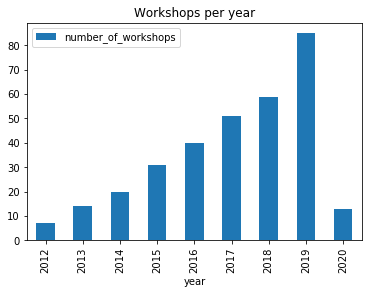

In [23]:
# How many workshops are there for each year?
workshops_per_year = workshops_df['year'].value_counts()
workshops_per_year.sort_index(ascending = True, inplace=True)
workshops_per_year.index.name = 'year'
print(workshops_per_year.index.dtype)
workshops_per_year.index = workshops_per_year.index.astype(int)
print(workshops_per_year.index.dtype)
print(workshops_per_year.index)
workshops_per_year = workshops_per_year.to_frame('number_of_workshops')
print(workshops_per_year)
workshops_per_year.plot(kind='bar', legend=True, title ="Workshops per year")

               number_of_workshops
workshop_type                     
SWC                            232
DC                              59
TTT                             15
Circuits                         7
LC                               7


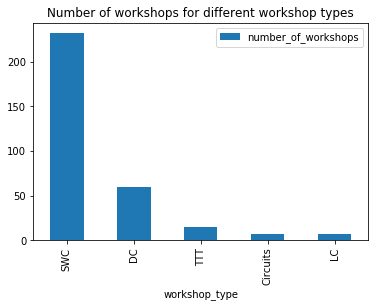

In [24]:
# How many SWC, DC, LC, TTT workshops were held so far?
workshops_per_type = workshops_df['workshop_type'].value_counts()
workshops_per_type.index.name = 'workshop_type'
workshops_per_type = workshops_per_type.to_frame('number_of_workshops')
print(workshops_per_type)
workshops_per_type.plot(kind='bar', legend=True, title ="Number of workshops for different workshop types")

workshop_type  Circuits  DC  LC  SWC  TTT
year                                     
2012.0                0   0   0    7    0
2013.0                0   0   0   14    0
2014.0                0   0   0   20    0
2015.0                0   2   1   24    4
2016.0                0   7   0   30    3
2017.0                0  12   2   33    4
2018.0                0  11   2   45    1
2019.0                6  25   1   50    3
2020.0                1   2   1    9    0


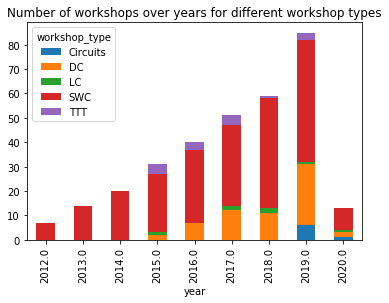

In [25]:
# How are numbers of different workshops (SWC, DC, LC, TTT) changing over years?
workshops_per_type_per_year = workshops_df.groupby(['workshop_type', 'year'])['workshop_type'].count().unstack('workshop_type').fillna(0).astype(dtype='int')
workshops_per_type_per_year.plot(kind='bar', stacked=True, title="Number of workshops over years for different workshop types")
print(workshops_per_type_per_year)

In [26]:
print(workshops_per_type_per_year.columns)

Index(['Circuits', 'DC', 'LC', 'SWC', 'TTT'], dtype='object', name='workshop_type')


ucl.ac.uk            34
ed.ac.uk             33
manchester.ac.uk     32
imperial.ac.uk       22
elixir-uk.org        19
leeds.ac.uk          18
ox.ac.uk             15
southampton.ac.uk    14
cam.ac.uk            11
st-andrews.ac.uk     10
swansea.ac.uk        10
bham.ac.uk           10
earlham.ac.uk         9
kcl.ac.uk             8
aber.ac.uk            5
anthro.ox.ac.uk       4
bristol.ac.uk         4
dundee.ac.uk          4
epcc.ed.ac.uk         3
qmul.ac.uk            3
shef.ac.uk            3
tgac.ac.uk            3
ncl.ac.uk             2
gla.ac.uk             2
exeter.ac.uk          2
york.ac.uk            2
nottingham.ac.uk      2
surrey.ac.uk          2
hw.ac.uk              2
nhm.ac.uk             2
rhul.ac.uk            2
qub.ac.uk             2
crick.ac.uk           2
supa.ac.uk            1
nls.uk                1
stfc.ac.uk            1
ccfe.ac.uk            1
greenwich.gov.uk      1
warwick.ac.uk         1
port.ac.uk            1
archives.org.uk       1
turing.ac.uk    

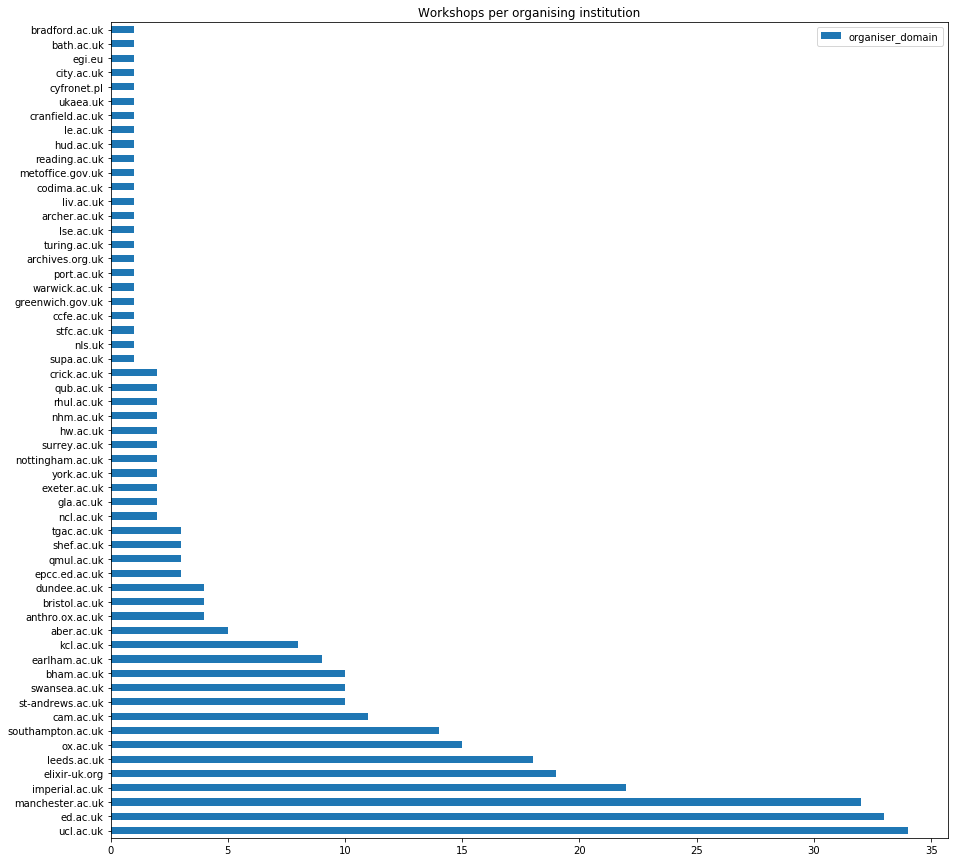

In [27]:
# How many workshops were held at each host institution?
workshops_per_host = workshops_df['organiser_domain'].value_counts()
print(workshops_per_host)
workshops_per_host.plot(kind='barh', legend=True, title ="Workshops per organising institution", figsize = (15,15))

Workshops with no region: 
Northern Ireland             2
North East                   3
East Midlands                6
South West                   8
West Midlands               11
Wales                       14
Eastern                     23
Yorkshire and The Humber    24
North West                  31
South East                  40
Scotland                    51
London                      71
Name: region, dtype: int64
Total number of workshops: 284


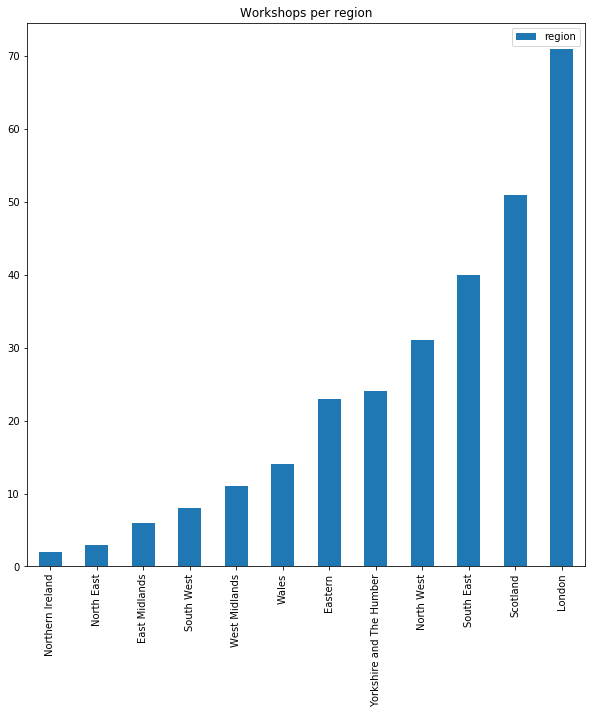

In [28]:
# How many workshops were held at each region?
print("Workshops with no region: ")
workshops_df[workshops_df['region']==""]

workshops_per_region = workshops_df['region'].value_counts().sort_values()
print(workshops_per_region)
total_no_workshops = workshops_per_region.sum()
print("Total number of workshops: " +str(total_no_workshops))
workshops_per_region.plot(kind='bar', legend=True, title ="Workshops per region", figsize = (10,10))

region
East Midlands                6
Eastern                     23
London                      71
North East                   3
North West                  31
Northern Ireland             2
Scotland                    51
South East                  40
South West                   8
Wales                       14
West Midlands               11
Yorkshire and The Humber    24
dtype: int64
workshop_type             Circuits  DC  LC  SWC  TTT  total
region                                                     
Northern Ireland                 0   1   0    1    0      2
North East                       1   0   0    2    0      3
East Midlands                    0   0   0    6    0      6
South West                       0   0   0    7    1      8
West Midlands                    0   0   0   11    0     11
Wales                            2   2   0   10    0     14
Eastern                          0  12   1    9    1     23
Yorkshire and The Humber         0   4   1   17    2     24
North We

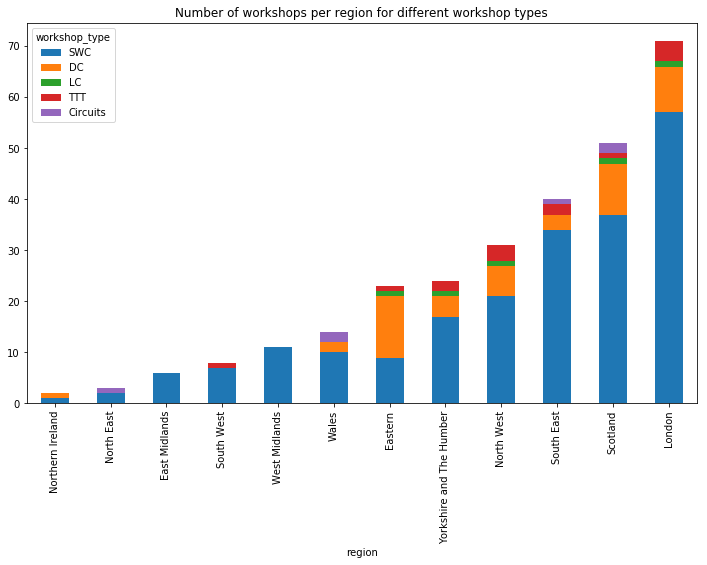

In [29]:
# How are numbers of different workshop types (SWC, DC, LC, TTT) looking per regions?
workshops_per_type_per_region = workshops_df.groupby(['workshop_type', 'region'])['workshop_type'].count().unstack('workshop_type').fillna(0).astype(dtype='int')
print(workshops_per_type_per_region.sum(axis = 1, skipna = True))
workshops_per_type_per_region['total'] = workshops_per_type_per_region.sum(axis = 1, skipna = True)
workshops_per_type_per_region = workshops_per_type_per_region.sort_values(axis = 0, by=['total'])
workshops_per_type_per_region[WORKSHOP_TYPES].plot(kind='bar', stacked=True, title="Number of workshops per region for different workshop types", figsize = (12,7))
print(workshops_per_type_per_region)

Total number of workshops: 284
                                            region  workshop_count  \
region                                                               
Northern Ireland                  Northern Ireland               2   
North East                              North East               3   
East Midlands                        East Midlands               6   
South West                              South West               8   
West Midlands                        West Midlands              11   
Wales                                        Wales              14   
Eastern                                    Eastern              23   
Yorkshire and The Humber  Yorkshire and The Humber              24   
North West                              North West              31   
South East                              South East              40   
Scotland                                  Scotland              51   
London                                      London         

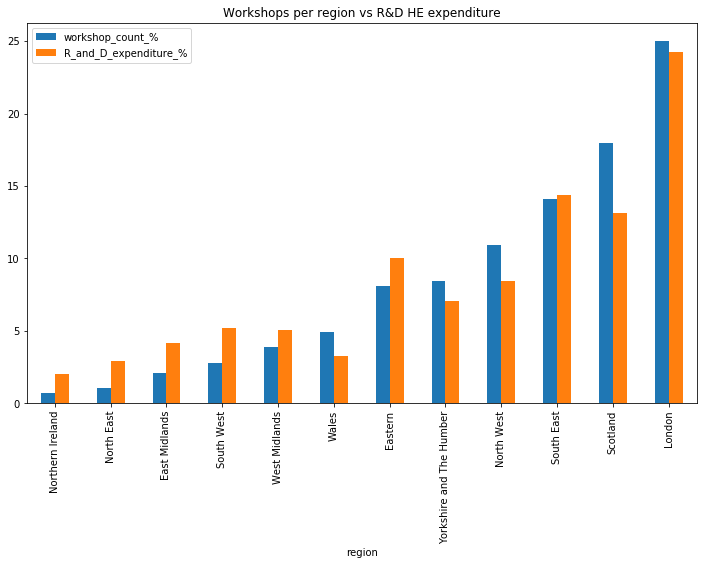

In [30]:
# Add R&D expenditure per region and let's plot that alongside workshops per region to see how they match
R_and_D_expenditure = pd.read_csv(CURRENT_DIR +"/lib/R_and_D_expenditure-for-HE.csv", encoding = "utf-8")
R_and_D_expenditure_mapping = dict(R_and_D_expenditure[['Region','% of total R&D expenditure']].values)
workshops_per_region_df = pd.DataFrame()
workshops_per_region_df['region'] = workshops_per_region.index
workshops_per_region_df['workshop_count'] = workshops_per_region.index
workshops_per_region_df['workshop_count'] = workshops_per_region_df['workshop_count'].map(workshops_per_region)
workshops_per_region_df['R_and_D_expenditure_%'] = workshops_per_region_df['region'].map(R_and_D_expenditure_mapping)
total_no_workshops = workshops_per_region.sum()
workshops_per_region_df['workshop_count_%'] = (workshops_per_region_df['workshop_count']/total_no_workshops)*100
workshops_per_region_df.index = workshops_per_region_df['region']
print("Total number of workshops: " +str(total_no_workshops))
print(workshops_per_region_df)
workshops_per_region_df[['workshop_count_%', 'R_and_D_expenditure_%']].plot(kind='bar', legend=True, title ="Workshops per region vs R&D HE expenditure", figsize = (12,7))


All workshops we have domains for:

0                                      [Don't know yet]
1                  [Genetics, genomics, bioinformatics]
2     [Planetary sciences (geology, climatology, oce...
3                                      [Don't know yet]
4     [Organismal biology (ecology, botany, zoology,...
5        [Genetics, genomics, bioinformatics, Medicine]
6                                      [Don't know yet]
7                                     [Social sciences]
8                              [Mathematics/statistics]
9                  [Genetics, genomics, bioinformatics]
10                                            [Physics]
11                 [Genetics, genomics, bioinformatics]
12                                     [Don't know yet]
13                                     [Don't know yet]
14                 [Genetics, genomics, bioinformatics]
15                                     [Don't know yet]
16    [Space sciences, Planetary sciences (geology, ...
17         

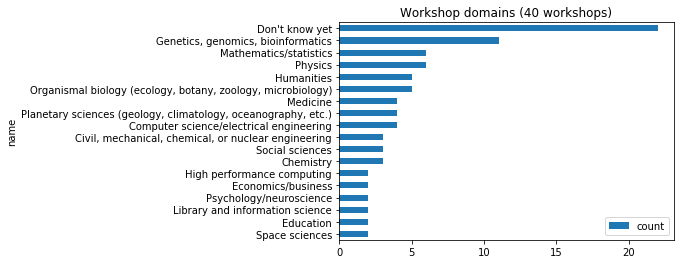

In [31]:
# How about workshop domains?
workshop_domains_file = DATA_DIR + "/raw/redash_workshops_UK_domains_2020_02_21.csv"
workshop_domains = pd.read_csv(workshop_domains_file, encoding = "utf-8")
workshop_domains["domains_list"] = workshop_domains["workshop_request_domains"].str.split(':')
# workshop_domains
print("\nAll workshops we have domains for:\n")
print(workshop_domains["domains_list"])

# Get rid of all 'stopped' workshops
# First - convert column "tags" from a string to a list of strings
idx = workshop_domains.columns.get_loc("workshop_tags")
workshop_domains.insert(loc=idx, column='tags_list', value=workshop_domains["workshop_tags"])
workshop_domains["tags_list"] = workshop_domains["workshop_tags"].str.split(',')
# Now extract the workshop status, normally ('cancelled', 'unresponsive', 'stalled'), from tags_list
idx = workshop_domains.columns.get_loc("tags_list")
workshop_domains.insert(loc=idx, column='workshop_status',
                            value=workshop_domains["tags_list"])
workshop_domains["workshop_status"] = workshop_domains["tags_list"].map(helper.extract_workshop_status, na_action="ignore")
# print(workshop_domains[["workshop_slug", "workshop_status"]])
# Finally, get rid of all "stalled", "cancelled" and "unresponsive" workshops for further analyses
# print("Number of workshops that did not go ahead: " + 
#       str(workshop_domains[(workshop_domains['workshop_status'].isin(STOPPED_WORKSHOP_TYPES))]['workshop_status'].count()))
workshop_domains = workshop_domains[(~workshop_domains['workshop_status'].isin(STOPPED_WORKSHOP_TYPES))]
# print("\nWorkshops after removing the ones that did not go ahead:\n")
# print(workshop_domains[["workshop_slug", "workshop_status"]])

# print("\nAll domains:\n")
domains = pd.read_csv(CURRENT_DIR + "/lib/all_domains.csv", encoding = "utf-8")
# print(domains)
# count = workshop_domains["domains_list"].apply(lambda x: value in x).sum()
domains["count"] = domains["name"].apply(lambda domain: workshop_domains["domains_list"].apply(lambda x: domain in x).sum())
domains.index = domains["name"]
domains = domains.sort_values(by=['count'])

total_workshops = workshop_domains['workshop_status'].count()
print("\nOccurances of domains for " + str(total_workshops) + " workshops:\n")
print(domains)

domains.plot(kind='barh', title="Workshop domains (" + str(total_workshops) + " workshops)")


year
2012.0     228
2013.0     439
2014.0     509
2015.0     898
2016.0     839
2017.0    1126
2018.0     921
2019.0     771
2020.0       0
Name: attendance, dtype: int64


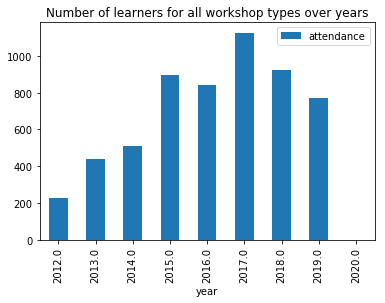

In [32]:
# How many learners attended workshops over years?
attendance_per_year = workshops_df.groupby(['year'])["attendance"].sum().fillna(0).astype("int")
print(attendance_per_year)
attendance_per_year.plot(kind='bar', legend=True, title ="Number of learners for all workshop types over years")

Average workshop attendance: 18

year
2012.0     228
2013.0     439
2014.0     509
2015.0     898
2016.0     839
2017.0    1126
2018.0     921
2019.0     771
2020.0       0
Name: attendance, dtype: int64


/Users/alex/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


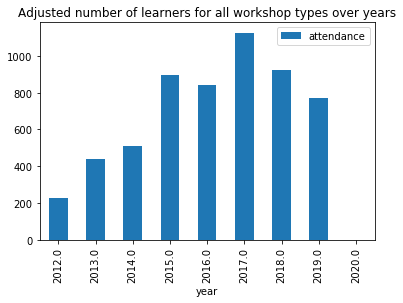

In [33]:
# How many learners attended workshops over years (with adjustments for missing attendance data with average attendance)?

# Disregard TTT workshops as they have attendance capped at 20 most of the times
average_attendance = round(workshops_df[workshops_df["workshop_type"] != "TTT"]["attendance"].mean())
print("Average workshop attendance: " + str(average_attendance) + "\n")
# Adjusted attendance over year data and graph
workshops_df["attendance"].fillna(average_attendance, inplace=True)
attendance_per_year = workshops_df.groupby(['year'])["attendance"].sum().astype("int")
print(attendance_per_year)
attendance_per_year.plot(kind='bar', legend=True, title ="Adjusted number of learners for all workshop types over years")

workshop_type
Circuits       0
DC           947
LC           164
SWC         4395
TTT          225
Name: attendance, dtype: int64


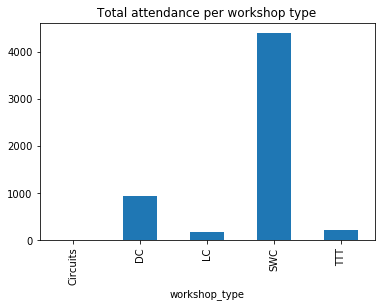

In [34]:
# Total attendance for different workshop types (with missing data adjusted with average attendance)
attendance_per_type = workshops_df.groupby(['workshop_type'])['attendance'].sum().astype("int")
print(attendance_per_type)
attendance_per_type.plot(kind="bar", title="Total attendance per workshop type")

workshop_type  Circuits   DC  LC  SWC  TTT
year                                      
2012.0                0    0   0  228    0
2013.0                0    0   0  439    0
2014.0                0    0   0  509    0
2015.0                0   78  59  686   75
2016.0                0  144   0  635   60
2017.0                0  284  51  706   85
2018.0                0  156  54  706    5
2019.0                0  285   0  486    0
2020.0                0    0   0    0    0


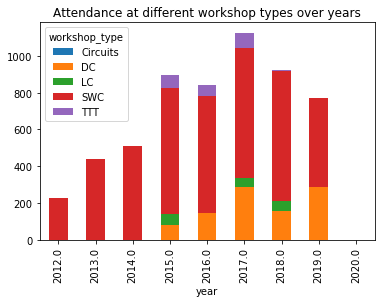

In [35]:
# How many learners attended each of (SWC, DC, LC, TTT) workshops over years (missing data adjusted by average attendance)?
attendance_per_type_per_year = workshops_df.groupby(['workshop_type', 'year'])['attendance'].sum().unstack("workshop_type").fillna(0).astype("int")
print(attendance_per_type_per_year)
attendance_per_type_per_year.plot(kind='bar', stacked=True, title="Attendance at different workshop types over years")


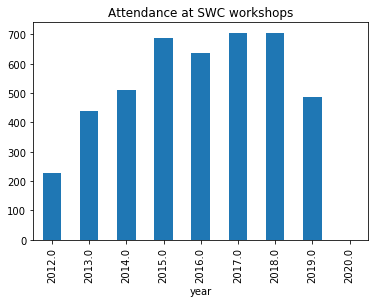

In [36]:
# Attendance just for SWC workshops over years
# Can be done similarly for DC, LC, TTT workshops, this is just an example
attendance_per_type_per_year["SWC"].plot(kind='bar', title="Attendance at SWC workshops")

                          number_of_workshops
region                                       
London                                     71
Scotland                                   51
South East                                 40
North West                                 31
Yorkshire and The Humber                   24
Eastern                                    23
Wales                                      14
West Midlands                              11
South West                                  8
East Midlands                               6
North East                                  3
Northern Ireland                            2


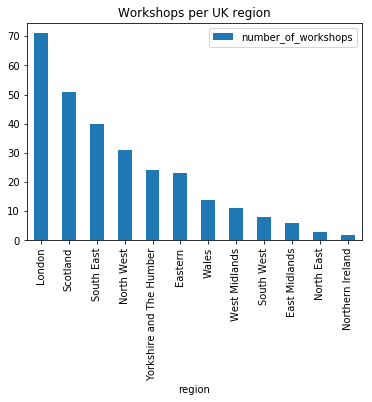

In [37]:
# How are workshops spread over UK regions? - plot workshops over UK regions
workshops_per_UK_region = workshops_df['region'].value_counts()
workshops_per_UK_region.index.name = 'region'
workshops_per_UK_region = workshops_per_UK_region.to_frame('number_of_workshops')
print(workshops_per_UK_region)
workshops_per_UK_region.plot(kind='bar', legend=True, title ="Workshops per UK region")

In [60]:
# Save all analyses into an Excel spreadsheet
ANALYSES_DIR = "data/analyses/"
if not os.path.exists(ANALYSES_DIR):
    os.makedirs(ANALYSES_DIR)

workshops_file_name = os.path.basename(workshops_file)
workshops_file_name_without_extension = re.sub('\.csv$', '', workshops_file_name.strip())
workshop_analyses_excel_file = ANALYSES_DIR + "analysed_" + workshops_file_name_without_extension + '_from_ipynb.xlsx'

excel_writer = pd.ExcelWriter(workshop_analyses_excel_file, engine='xlsxwriter')

workshops_df.to_excel(excel_writer, sheet_name=os.path.splitext(workshops_file_name)[0][:31], index=False)

# Write README
workbook = excel_writer.book
worksheet = workbook.add_worksheet('README')
readme_text = "Analyses done using code from 'outcome2.1' branch: " + \
"https://github.com/softwaresaved/carpentry-workshops-instructors-extractor/tree/outcome2.1 and" + \
"saved to file " + workshop_analyses_excel_file + " which was then uploaded to this sheet in Google drive." 
worksheet.write(0, 0, readme_text)
readme_text = "Raw files and analyses files available from the following tag: " + \
"https://github.com/softwaresaved/carpentry-workshops-instructors-extractor/tree/ad-board-march-2020 " + \
"Raw files and analyses files available from the following tag: " +\
"https://github.com/softwaresaved/carpentry-workshops-instructors-extractor/tree/ad-board-march-2020"
worksheet.write(2, 0, readme_text)

# Write UK academic insitutions table we used for lookup
uk_academic_institutions.to_excel(excel_writer, sheet_name='uk_academic_institutions', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['uk_academic_institutions']

# Workshops per year
workshops_per_year.to_excel(excel_writer, sheet_name='workshops_per_year', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_year']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['workshops_per_year', 1, 0, len(workshops_per_year.index), 0],
        'values': ['workshops_per_year', 1, 1, len(workshops_per_year.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Year'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops per year'})
worksheet.insert_chart('I2', chart)

# Workshops per type   
workshops_per_type.to_excel(excel_writer, sheet_name='workshops_per_type', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_type']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['workshops_per_type', 1, 0, len(workshops_per_type.index), 0],
        'values': ['workshops_per_type', 1, 1, len(workshops_per_type.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Workshop type'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops of different types'})
worksheet.insert_chart('I2', chart)
    
# Workshops per type per year
workshops_per_type_per_year.to_excel(excel_writer, sheet_name='workshops_per_type_per_year', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_type_per_year']
chart = workbook.add_chart({'type': 'column', 'subtype': 'stacked'})
for i in range(1, len(workshops_per_type_per_year.columns) + 1):
    chart.add_series({
            'name': ['workshops_per_type_per_year', 0, i],
            'categories': ['workshops_per_type_per_year', i, 0, len(workshops_per_type_per_year.index), 0],
            'values': ['workshops_per_type_per_year', 1, i, len(workshops_per_type_per_year.index), i],
            'gap': 2,
        })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_x_axis({'name': 'Year'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops of different types over years'})
worksheet.insert_chart('B20', chart)

# Workshops per host
workshops_per_host.to_excel(excel_writer, sheet_name='workshops_per_host', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_host']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['workshops_per_host', 1, 0, len(workshops_per_host.index), 0],
        'values': ['workshops_per_host', 1, 1, len(workshops_per_host.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Host institution'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops per host'})
worksheet.insert_chart('I2', chart)

# Workshops per region
workshops_per_region.to_excel(excel_writer, sheet_name='workshops_per_region', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_region']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['workshops_per_region', 1, 0, len(workshops_per_region.index), 0],
        'values': ['workshops_per_region', 1, 1, len(workshops_per_region.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Host institution'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops per region'})
worksheet.insert_chart('I2', chart)

# Workshops per type per region
workshops_per_type_per_region.to_excel(excel_writer, sheet_name='workshops_per_type_per_region', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_type_per_region']
chart = workbook.add_chart({'type': 'column', 'subtype': 'stacked'})
for i in range(1, len(workshops_per_type_per_region[WORKSHOP_TYPES].columns) + 1):
    chart.add_series({
            'name': ['workshops_per_type_per_region', 0, i],
            'categories': ['workshops_per_type_per_region', i, 0, len(workshops_per_type_per_region[WORKSHOP_TYPES].index), 0],
            'values': ['workshops_per_type_per_region', 1, i, len(workshops_per_type_per_region[WORKSHOP_TYPES].index), i],
            'gap': 2,
        })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_x_axis({'name': 'Region'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops of different type per region'})
worksheet.insert_chart('B20', chart)

# Write R&D expenditure table we used for lookup
R_and_D_expenditure.to_excel(excel_writer, sheet_name='R_and_D_expenditure', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['R_and_D_expenditure']

# R&D expenditure vs workshop numbers per region
workshops_per_region_df.to_excel(excel_writer, sheet_name='R&D_expenditure_vs_workshops', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['R&D_expenditure_vs_workshops']
chart = workbook.add_chart({'type': 'column'})
# Some alternative colors for the 2 charts
colors = ['#ffa500', '#377EB8']#, '#4DAF4A', '#984EA3', '#FF7F00']
# Column numbers we are plotting
columns_to_plot = [list(workshops_per_region_df.columns).index("R_and_D_expenditure_%"),
                   list(workshops_per_region_df.columns).index("workshop_count_%")]
# Add series from the dataframe data that we want to plot.
# [sheetname, first_row, first_col, last_row, last_col]
for i in range(0, len(columns_to_plot)):
    chart.add_series({
        'name':       ['R&D_expenditure_vs_workshops', 0, columns_to_plot[i] + 1],
        'categories': ['R&D_expenditure_vs_workshops', 1, 0, len(workshops_per_region_df.index), 0],
        'values':     ['R&D_expenditure_vs_workshops', 1, columns_to_plot[i] + 1, len(workshops_per_region_df.index), columns_to_plot[i] + 1],
        'fill':       {'color':  colors[i]},
        'overlap':    -10,
    })
chart.set_x_axis({'name': 'R&D expenditure per region'})
chart.set_y_axis({'name': '%', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'R&D expenditure vs workshop numbers per region'})
worksheet.insert_chart('I2', chart)

# Workshop domains
domains['count'].to_excel(excel_writer, sheet_name='workshops_domains', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_domains']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['workshops_domains', 1, 0, len(domains.index), 0],
        'values': ['workshops_domains', 1, 1, len(domains.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Domains'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops per domain' + ' (based on ' + 
                 str( workshop_domains['workshop_status'].count()) + ' workshops)'})
worksheet.insert_chart('I2', chart)

# # Workshop attendance per year
# attendance_per_year.to_excel(excel_writer, sheet_name='attendance_per_year', index=True)
# workbook = excel_writer.book
# worksheet = excel_writer.sheets['attendance_per_year']
# chart = workbook.add_chart({'type': 'column'})
# chart.add_series({
#         'categories': ['attendance_per_year', 1, 0, len(attendance_per_year.index), 0],
#         'values': ['attendance_per_year', 1, 1, len(attendance_per_year.index), 1],
#         'gap': 2,
#     })
# chart.set_y_axis({'major_gridlines': {'visible': False}})
# chart.set_legend({'position': 'none'})
# chart.set_x_axis({'name': 'Year'})
# chart.set_y_axis({'name': 'Number of attendees', 'major_gridlines': {'visible': False}})
# chart.set_title({'name': 'Number of attendees per year (with estimates for missing data)'})
# worksheet.insert_chart('I2', chart)

# # Workshop attendance per workshop type
# attendance_per_type.to_excel(excel_writer, sheet_name='attendance_per_type', index=True)
# workbook = excel_writer.book
# worksheet = excel_writer.sheets['attendance_per_type']
# chart = workbook.add_chart({'type': 'column'})
# chart.add_series({
#         'categories': ['attendance_per_type', 1, 0, len(attendance_per_type.index), 0],
#         'values': ['attendance_per_type', 1, 1, len(attendance_per_type.index), 1],
#         'gap': 2,
#     })
# chart.set_y_axis({'major_gridlines': {'visible': False}})
# chart.set_legend({'position': 'none'})
# chart.set_x_axis({'name': 'Workshop type'})
# chart.set_y_axis({'name': 'Number of attendees', 'major_gridlines': {'visible': False}})
# chart.set_title({'name': 'Number of attendees per workshop type (with estimates for missing data)'})
# worksheet.insert_chart('I2', chart)

# # Workshop attendance per workshop type per year
# attendance_per_type_per_year.to_excel(excel_writer, sheet_name='attendance_per_type_per_year', index=True)
# workbook = excel_writer.book
# worksheet = excel_writer.sheets['attendance_per_type_per_year']
# chart = workbook.add_chart({'type': 'column', 'subtype': 'stacked'})
# for i in range(1, len(attendance_per_type_per_year.columns) + 1):
#     chart.add_series({
#             'name': ['attendance_per_type_per_year', 0, i],
#             'categories': ['attendance_per_type_per_year', i, 0, len(attendance_per_type_per_year.index), 0],
#             'values': ['attendance_per_type_per_year', 1, i, len(attendance_per_type_per_year.index), i],
#             'gap': 2,
#         })
# chart.set_y_axis({'major_gridlines': {'visible': False}})
# chart.set_x_axis({'name': 'Year'})
# chart.set_y_axis({'name': 'Attendance', 'major_gridlines': {'visible': False}})
# chart.set_title({'name': 'Attendance at workshops of different types over years (with estimates for missing data)'})
# worksheet.insert_chart('B20', chart)

excel_writer.save()
print("Saved workshop analyses in " + workshop_analyses_excel_file)

Saved workshop analyses in data/analyses/analysed_redash_workshops_UK_2020_02_24_from_ipynb.xlsx
